# CSFundamental Report 3
M1 Shusei Komatsu  
Student Number: B8IM2019

# Contents
- Aim
- Preparation
    - Preparing Pokemons lists
    - Review of the original Python code
- Which is the strongest Pokemon?
    - Normal Round Robin Experiment
    - Speed Battle
    - Why is the strongest Pokemon is so strong?
    - What if we knew the enemy Pokemon?
- What is the strongest Pokemon team?
    - Team Battle
    - Random Battle
    - Team Training Algorithm
    - S-Team Training Algorithm
    - What if we could put same monsters in a team?
    - What if we knew the enemy team?
    - What if we could add same monsters in a team and knew the enemy team?
- Conclusion and comments

# Aim
In this homework, we design experiments to find out the strongest pokemon and pokemon team.  
Through the homework, we report the results and comments with their insights and deepen it by some more experiments.  
Finally, we conclude the results of the experiments and give some comments.

# Preparation
In this section, we prepare pokeList and pokedex which have Pokemon information.  
After that, we review the given python code and make some improvement.  

## Preparing Pokemons lists
To begin with, we need lists of Pokemons so that we can access the pokemons conveniently. We use given original functions to get them.

In [3]:
from lesson3Code.pokemonTournament.pokemonDef import Monster,superEffective,notEffective,noEffect
import lesson3Code.pokemonTournament.pokemonFunctions as pf

listOfNamesAndTypes=pf.readPokemonTypesFromFile("lesson3Code/pokemonTournament/listOfPokemon1.txt")
pokeList=pf.readPokemonListFromFile("lesson3Code/pokemonTournament/listOfPokemon2.txt")

pokedex={}
for monster in pokeList:
    pokedex[monster.name]=monster

for name,listOfTypes in listOfNamesAndTypes:
    for t in listOfTypes:
        pokedex[name].variety.append(t)

## Review of the original Python code
In the given code, there are functions to make pokemon information list, battle, dype definition and so on.  
Here, we make some improvements to the oritinal Python code.

### Aquiring Data
In the code above, we used readPokemonTypesFromFile function.The function reads the rows that have weak point types of the Pokemon that is not actually the type of the Pokemon. So we ignore those rows.

29: # Lines with 2 #s have weak point types. So they should be ignored  
30: if readList[1][0] != '#': return(readList[2], typeList) 

### Battle function  

In the battle function, there is inverse judge of "No effect" type.  We correct the code like below.

lesson3Code/pokemonTournament/pokemonFunctions.py  
80: if noEffect(Pokemon1, Pokemon2):  
↓  
80: if noEffect(Pokemon2, Pokemon1):  

### Copying Monster named tuple
When 2 same Pokemon battle each other, if one of them gets damaged, the another gets same damage in the original implementation. Because if we send 2 same pokemons from pokeList, they share same address of the monster. To prevent this, we define copyMonster function to create same Monster named tuple but has different address.

In [4]:
import numpy as np
from copy import copy

def copyMonster(p):
    return Monster(*[copy(f) for f in p])

pid = np.random.randint(0, len(pokeList))
p1 = copyMonster(pokeList[pid])
p2 = copyMonster(p1)
print(p1)
print(p2)

p1.hitpoint[1] = 0

print(p1)
print(p2)
print(pokeList[pid])

Monster(name='Diglett', index=49, attack=55, defense=25, speed=45, hitpoint=[10, 10], variety=['Ground'])
Monster(name='Diglett', index=49, attack=55, defense=25, speed=45, hitpoint=[10, 10], variety=['Ground'])
Monster(name='Diglett', index=49, attack=55, defense=25, speed=45, hitpoint=[10, 0], variety=['Ground'])
Monster(name='Diglett', index=49, attack=55, defense=25, speed=45, hitpoint=[10, 10], variety=['Ground'])
Monster(name='Diglett', index=49, attack=55, defense=25, speed=45, hitpoint=[10, 10], variety=['Ground'])


# Which is the strongest Pokemon?
Anyway, we have Pokemons battle each other as round-robin battle experiment, then the Pokemon which has the most number of win is the strongest Pokemon.  
Ordering the pokemons along numbers of win, we can make the pokemon ranking.  
The battle combat system relies uniform distribution when a Pokemon attacks the enemy Pokemon. So we make Pokemons battle enough times. We name the number of battle as $k$.

In [6]:
def SingleRoundRobinExperiment(p, enemy_list=pokeList, k=1, battle=pf.battle, skip_same=False, verbose=False):
    results = np.zeros(len(enemy_list), dtype=[('w','i'), ('l', 'i'), ('d', 'i')]) # win, loss, draw
    for idx, enemy in enumerate(enemy_list):
        if skip_same and p.name == enemy.name: continue
        for i in range(k):
            result = battle(copyMonster(p), copyMonster(enemy))
            if result == 0: results[idx]['w'] += 1
            elif result == 1: results[idx]['l'] += 1
            else: results[idx]['d'] += 1
    return results

In [7]:
def RoundRobinExperiment(k=1, battle=pf.battle, verbose=False):
    get_result = lambda p: SingleRoundRobinExperiment(p, k=k, battle=battle, verbose=verbose)
    results = np.array([get_result(p) for p in pokeList]) # battles results win-loss-draw, the indices represents pokemon indices

    if verbose:
        ranking = results['w'].sum(axis=0).argsort()
        strongest = pokeList[ranking[0]]
        print("The strongest pokemon is", strongest.name, "id:", strongest.index)
        print("The strongest pokemon parameter", strongest)
        print("Strongest Pokemon Top 10")
        for i in ranking[:10]:
            print(pokeList[i])
    
    return results

In [9]:
import pickle
k = 100

try:
    # raise Exception # For creating new pickle data
    with open('data/normal_result.pkl', 'rb') as f:
        normal_result = pickle.load(f)
        print('normal result is loaded from the pickle file')
except:
    normal_result = RoundRobinExperiment(k, verbose=True)
    with open('data/normal_result.pkl', mode='wb') as f:
        pickle.dump(normal_result, f)
finally:
    normal_ranking = [pokeList[p] for p in normal_result['w'].sum(axis=0).argsort()]

normal result is loaded from the pickle file


Here we used pickle to save result data as round-robin experiment takes long time.  
<br>
Below is the strongest pokemon follows round-robin experiment.

In [10]:
normal_ranking[0]

Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])

Features of round-robin experiment  
- Time orders ($n$: # of Pokemons)
    - One round-robin experiment $O(n^2)$
    - $k$ round-robin experiments $O(kn^2)$
- Advantages
    - This method realizes high accuracy of the strongness as we use real combat function.
    - We can measure relative relation of strongness without detail parameter.
    - Easy to implement.
- Disadvantages
    - This method takes a lot of times. Real combat function costs much time generally.
    - Real combat battle relies random variables. So for each experiments, we get slightly different results.

## Speed Battle
pf.battle is clearly slow.  
A lot of time is consumed in the battles that both of Pokemons give 0 damage each other, then max round reaches. To reduce consumed time in this case, we set max_round=100, not 1000.  
<br>
However, if we get battle result from the parameter by simulating the real combat battle, it would be much faster than normal battle function.
We implement SpeedBattle function in which we use parameters of pokemons, and replace random variables into their expected values, then the winner is decided by how many rounds each pokemon can survive.

In [11]:
def SpeedBattle(p1, p2, resetHP=True, verbose=False):
    
    max_rounds = 100
    effectiveness = 0.3
    expected_defense_rate = 0.75 # Setting this the lowest, accuracy increased
    
    if resetHP:
        pf.ResetHP(p1)
        pf.ResetHP(p2)
    
    if noEffect(p1, p2) and noEffect(p2, p1): return 2
    
    attackCenter1=1
    if superEffective(p1, p2): attackCenter1+=effectiveness
    if notEffective(p1, p2): attackCenter1-=effectiveness
    if noEffect(p1, p2): attackCenter1 = 0


    attackCenter2=1
    if superEffective(p2, p1): attackCenter2+=effectiveness
    if notEffective(p2, p1): attackCenter2-=effectiveness
    if noEffect(p2, p1): attackCenter2 = 0

    
    get_damage1 = max(0, (round(p2.attack * attackCenter2) - round(p1.defense * expected_defense_rate)))
    survive_rounds1 = min(max_rounds, (float(p1.hitpoint[1]) / get_damage1)) if get_damage1 > 0 else max_rounds
    get_damage2 = max(0, (round(p1.attack * attackCenter1) - round(p2.defense * expected_defense_rate)))
    survive_rounds2 = min(max_rounds, (float(p2.hitpoint[1]) / get_damage2)) if get_damage2 > 0 else max_rounds
        
    if survive_rounds1 == survive_rounds2: 
        if survive_rounds1 >= max_rounds: return 2
        if p1.speed == p2.speed: return 2
        return 0 if p1.speed > p2.speed else 1
    
    return 0 if survive_rounds1 > survive_rounds2 else 1

Here the expected defense rate is not middle of the range of defense in pf.battle.It is set lower. Because, it will be known later though, Pokemons who have high defense tend to be higher rank than ones in normal ranking.

In [12]:
# The result is deterministic. So it is enough for k to be 1.
speed_result = RoundRobinExperiment(battle=SpeedBattle, verbose=True)
speed_ranking = [pokeList[p] for p in speed_result['w'].sum(axis=0).argsort()]

The strongest pokemon is Cloyster id: 90
The strongest pokemon parameter Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Strongest Pokemon Top 10
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying'])
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 105], variety=['Ground', 'Rock'])
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, 95], variety=['Water', 'Flying'])
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Mewtwo', index=149, attack=110, defense=90, speed=154, hitpoint=[106, 106], variety=['Psychic'])
Monster(name='Golem', index=75, attack=110, defense=130, speed=55, hitpoint=[80, 80], variety=['Ro

The time order is still $O(n^2)$, however it becomes faster because we don't need make Pokemons battle acturally each other.  
How much faster than normal battle?

In [14]:
import time

startNormal = time.time()
RoundRobinExperiment() # 8 sec when max round was 1000
endNormal = time.time()
print("Normal Battle Elapsed Time:", endNormal - startNormal)

startSpeed = time.time()
RoundRobinExperiment(battle=SpeedBattle)
endSpeed = time.time()
print("Speed Battle Elapsed Time:", endSpeed - startSpeed)

Normal Battle Elapsed Time: 1.55686616897583
Speed Battle Elapsed Time: 0.4766981601715088


In this result, SpeedBattle tripled the speed of round-robin experiment.  
Then, how about the accuracy?

In [15]:
normal_ranking_id = np.array([p.index for p in normal_ranking]) 
speed_ranking_id = np.array([p.index for p in speed_ranking])
same_places = normal_ranking_id == speed_ranking_id
print(f"same places: {sum(same_places)} / {len(same_places)}")

same places: 20 / 151


There seems not no be so many Pokemons in same places with normal battle ranking.  
Next, we take Standerd Rank Error (SRE) that is square root of average square error between normal battle ranking and speed battle ranking.

In [17]:
import math

def std_rank_error(ranking, offset=0, verbose=False):
    normal_ranking_list = list(normal_ranking)
    ranking_error = []
    for rank, p in enumerate(ranking):
        diff = (normal_ranking_list.index(p) - rank - offset)
        if verbose: print(rank, normal_ranking_list.index(p), p.name, diff)
        ranking_error.append(diff ** 2)

    return math.sqrt(sum(ranking_error) / len(ranking_error))

print("Standard Rank Error:", std_rank_error(speed_ranking))

Standard Rank Error: 3.3116291183069615


This result means the expectation of differenses of ranks between normal battle ranking and speed battle ranking is about 3.  
Total number of Pokemons is 151, so this value seems to be a good result.

Finally, we visualise which rank areas have big SREs.

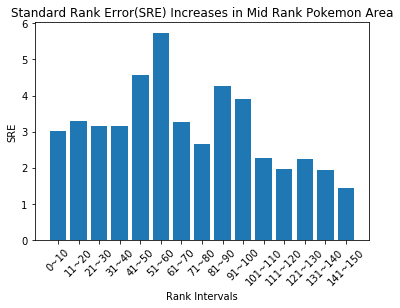

SREs
[3.02, 3.3, 3.16, 3.15, 4.56, 5.74, 3.27, 2.65, 4.25, 3.91, 2.28, 1.97, 2.24, 1.95, 1.45]


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

speed_ranking_id = [p.index for p in speed_ranking]
intervals = np.array_split(speed_ranking_id, 15)
y = [std_rank_error([pokeList[p] for p in interval], offset=speed_ranking_id.index(interval[0])) for interval in intervals]
x = [f"{speed_ranking_id.index(interval[0])}~{speed_ranking_id.index(interval[-1])}" for interval in intervals]
plt.bar(x,y)
plt.title("Standard Rank Error(SRE) Increases in Mid Rank Pokemon Area")
plt.xlabel("Rank Intervals")
plt.xticks(x, rotation=45)
plt.ylabel("SRE")
plt.show()
print("SREs")
print([round(y_i, 2) for y_i in y])

Looking at the figure above, Pokemons in mid-rank have big SREs.This means very strong Pokemons and very weak Pokemons tend to keep their rank regardless of their luck (related to random variables).  
Therefore, speed battle ranking is effective when we want strongest Pokemon ranking top 10, weakest Pokemon ranking top 10, and so on.  
It is beneficial to know such property of acceleration.

# Why is the strongest Pokemon is so strong?
Basically, I supporsed the strongest pokemon is one of the legend pokemons. However, the strongest one is Cloyster as a result.  
Let us check the status of Cloyster to find out the reason of the strongness.

In [23]:
strongest = normal_ranking[0]
print(strongest)

Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])


The biggest characteristic of Cloyster is its defense.  
We can expect there are not so many Pokemons who can hurt Cloyster.  

In [24]:
print("Pokemon Defense Ranking")
defense_ranking = np.argsort([p.defense for p in pokeList])[::-1]
for p in defense_ranking[:10]:
    print(pokeList[p])

Pokemon Defense Ranking
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Monster(name='Onix', index=94, attack=45, defense=160, speed=30, hitpoint=[35, 35], variety=['Rock', 'Ground'])
Monster(name='Golem', index=75, attack=110, defense=130, speed=55, hitpoint=[80, 80], variety=['Rock', 'Ground'])
Monster(name='Omastar', index=138, attack=60, defense=125, speed=115, hitpoint=[70, 70], variety=['Rock', 'Water'])
Monster(name='Weezing', index=109, attack=90, defense=120, speed=85, hitpoint=[65, 65], variety=['Poison'])
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 105], variety=['Ground', 'Rock'])
Monster(name='Graveler', index=74, attack=95, defense=115, speed=45, hitpoint=[55, 55], variety=['Rock', 'Ground'])
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Tangela', index=113, attack=55, defense=115, speed=100, h

Cloyster has the highest defense among all Pokemons.

In [25]:
print("Pokemon Attack Ranking")
attack_ranking = np.argsort([p.attack for p in pokeList])[::-1]
for p in attack_ranking[:10]:
    print(pokeList[p])

Pokemon Attack Ranking
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying'])
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 105], variety=['Ground', 'Rock'])
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Machamp', index=67, attack=130, defense=80, speed=65, hitpoint=[90, 90], variety=['Fighting'])
Monster(name='Flareon', index=135, attack=130, defense=60, speed=110, hitpoint=[65, 65], variety=['Fire'])
Monster(name='Pinsir', index=126, attack=125, defense=100, speed=55, hitpoint=[65, 65], variety=['Bug'])
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, 95], variety=['Water', 'Flying'])
Monster(name='Hitmonlee', index=105, attack=120, defense=53, speed=35, hitpoint=[50, 50], variety=['Fighting'])
Monster(name='Kabutops', index=140, attack=115, defense=105, speed=70, hitpoint

While Cloyster has defense 180, no one has such high parameter of attack.  
Let us check the least attack needed for giving at least 1 damage to Cloyster.

In [27]:
round(180 * 0.7) # defense is multiplied 0.7 in worst case in pf.battle.

126

Effective pokemons should have attack > 126  
Or who have varieties against Water and Ice are...
- Grass
- Electric
- Fighting
- Rock
- Steel

and have enough attack

In [29]:
effective_varieties = ['Grass', 'Electric', 'Fighting', 'Rock', 'Steel']
effective_pokeList = [p for p in pokeList if np.any([v in p.variety for v in effective_varieties]) or p.attack > 126]
winnable_pokeList = [p for p in effective_pokeList if p.attack * 1.3 * 1.2 > 180 * 0.7]
print("\n# of Pokemons who can give a damage to Cloyster:", len(winnable_pokeList), "/", len(pokeList))

for p in winnable_pokeList:
    print(p)


# of Pokemons who can give a damage to Cloyster: 23 / 151
Monster(name='Venusaur', index=2, attack=82, defense=83, speed=100, hitpoint=[80, 80], variety=['Grass', 'Poison'])
Monster(name='Raichu', index=25, attack=90, defense=55, speed=90, hitpoint=[60, 60], variety=['Electric'])
Monster(name='Parasect', index=46, attack=95, defense=80, speed=80, hitpoint=[60, 60], variety=['Bug', 'Grass'])
Monster(name='Primeape', index=56, attack=105, defense=60, speed=60, hitpoint=[65, 65], variety=['Fighting'])
Monster(name='Poliwrath', index=61, attack=85, defense=95, speed=70, hitpoint=[90, 90], variety=['Water', 'Fighting'])
Monster(name='Machoke', index=66, attack=100, defense=70, speed=50, hitpoint=[80, 80], variety=['Fighting'])
Monster(name='Machamp', index=67, attack=130, defense=80, speed=65, hitpoint=[90, 90], variety=['Fighting'])
Monster(name='Weepinbell', index=69, attack=90, defense=50, speed=85, hitpoint=[65, 65], variety=['Grass', 'Poison'])
Monster(name='Victreebel', index=70, att

Above only 23 Pokemons can hurt at least 1 damage to Cloyster.  
This is the reason of strongness of Cloyster.  
Then, which is the most effective Pokemon against Cloyster?  
We check it by experimenting win rate of battles with Cloyster.

In [30]:
k = 100
cloyster = pokedex["Cloyster"]
challengers = winnable_pokeList

win_times = np.zeros(len(challengers), dtype='i')
for i, challenger in enumerate(challengers):
    for _ in range(k):
        if pf.battle(challenger, cloyster) == 0: 
            win_times[i] += 1
            
ranking = win_times.argsort()[::-1]
for idx in ranking:
    print(f"Challenger {challengers[idx].name} Win Rate: {win_times[idx]}/{k}")

Challenger Rhydon Win Rate: 65/100
Challenger Machamp Win Rate: 43/100
Challenger Golem Win Rate: 10/100
Challenger Dragonite Win Rate: 5/100
Challenger Raichu Win Rate: 0/100
Challenger Parasect Win Rate: 0/100
Challenger Primeape Win Rate: 0/100
Challenger Poliwrath Win Rate: 0/100
Challenger Machoke Win Rate: 0/100
Challenger Weepinbell Win Rate: 0/100
Challenger Victreebel Win Rate: 0/100
Challenger Graveler Win Rate: 0/100
Challenger Kingler Win Rate: 0/100
Challenger Zapdos Win Rate: 0/100
Challenger Exeggutor Win Rate: 0/100
Challenger Hitmonlee Win Rate: 0/100
Challenger Hitmonchan Win Rate: 0/100
Challenger Rhyhorn Win Rate: 0/100
Challenger Electabuzz Win Rate: 0/100
Challenger Flareon Win Rate: 0/100
Challenger Kabutops Win Rate: 0/100
Challenger Aerodactyl Win Rate: 0/100
Challenger Venusaur Win Rate: 0/100


From this result, only Rhydon is effective (win rate > 0.5) against Cloyster.

## If we knew the enemy Pokemon
Here we remove a restriction that we don't know the enemy Pokemon before the battle.  
To win such battle, send Pokemon that has the most highest win rate against the enemy Pokemon. We call such Pokemon "natual enemy Pokemon".  
To make faster to get natural enemy Pokemon, we make natural enemies list.

In [31]:
def natural_enemies(p, enemy_list=pokeList, k=10, ranking=normal_ranking, battle=pf.battle, top=6, verbose=False):
    results = SingleRoundRobinExperiment(p, k=k, enemy_list=enemy_list, battle=battle, verbose=verbose)
    loss_times = results['l']
    
    # Higher possibility of loss, and then higher ranking
    id_ranking = [p.index for p in ranking]
    
    # the index is pokeID, and has negative loss_time and rank
    loss_times = np.array([(-loss_time, id_ranking.index(idx)) for idx, loss_time in enumerate(loss_times)], dtype=[('l', 'i'), ('r', 'i')])
    
    # firstly, order by negative loss_time, secondly, by ranking
    strongest_natural_enemy_ids = loss_times.argsort(order=['l', 'r'])[:top]
        
    if verbose:
        print(f"{p.index}. Natural Enemies to {p.name}")
        for idx, i in enumerate(strongest_natural_enemy_ids):
            print(f"{idx+1}. {pokeList[i].name}, loss-times: {-loss_times[i][0]} / {k}")
        print()

    return [pokeList[i] for i in strongest_natural_enemy_ids]

def natural_enemies_list(plist=pokeList, enemy_list=pokeList, k=10, ranking=normal_ranking, battle=pf.battle, top=6, verbose=False):
    return [natural_enemies(p, enemy_list=enemy_list, k=k, ranking=ranking, battle=battle, top=top, verbose=verbose) for p in plist]

In [32]:
try:
    # raise Exception # For creating new pickle file
    with open("data/natural_enemies_list.pkl", "rb") as f:
        ne_list = pickle.load(f)
        print("natural enemies list is loaded from pickle file")
except:
    ne_list = natural_enemies_list(k=1000, verbose=True)
    with open("data/natural_enemies_list.pkl", "wb") as f:
        pickle.dump(ne_list, f)

natural enemies list is loaded from pickle file


In [33]:
with open("data/natural_enemies_result.pkl", "rb") as f:
    ne_result = pickle.load(f)

print(ne_result)

0. Natural Enemies to Bulbasaur
1. Cloyster, loss-times: 1000 / 1000
2. Dragonite, loss-times: 1000 / 1000
3. Kingler, loss-times: 1000 / 1000
4. Rhydon, loss-times: 1000 / 1000
5. Gyarados, loss-times: 1000 / 1000
6. Mewtwo, loss-times: 1000 / 1000

1. Natural Enemies to Ivysaur
1. Cloyster, loss-times: 1000 / 1000
2. Dragonite, loss-times: 1000 / 1000
3. Kingler, loss-times: 1000 / 1000
4. Rhydon, loss-times: 1000 / 1000
5. Gyarados, loss-times: 1000 / 1000
6. Mewtwo, loss-times: 1000 / 1000

2. Natural Enemies to Venusaur
1. Cloyster, loss-times: 1000 / 1000
2. Dragonite, loss-times: 1000 / 1000
3. Rhydon, loss-times: 1000 / 1000
4. Gyarados, loss-times: 1000 / 1000
5. Mewtwo, loss-times: 1000 / 1000
6. Mew, loss-times: 1000 / 1000

3. Natural Enemies to Charmander
1. Cloyster, loss-times: 1000 / 1000
2. Dragonite, loss-times: 1000 / 1000
3. Kingler, loss-times: 1000 / 1000
4. Rhydon, loss-times: 1000 / 1000
5. Gyarados, loss-times: 1000 / 1000
6. Mewtwo, loss-times: 1000 / 1000

4.

Now let us start random battle using natural enemies list.

In [38]:
k = 100000
loss_count = 0
ne_loss_list = []
for i in range(k):
    enemy_id = np.random.randint(len(pokeList))
    enemy = copyMonster(pokeList[enemy_id])
    natural_enemy = copyMonster(ne_list[enemy_id][0])
    result = pf.battle(natural_enemy, enemy, verbose=False)
    if result == 1:
        loss_count += 1
        ne_loss_list.append((natural_enemy, enemy))
        print("Natural Enemy Lose!")
        print("Natural Enemy:", natural_enemy.name)
        print('vs')
        print("Enemy:", enemy.name)
        print()

print(f"Natural Enemy Lose: {loss_count} times. Win rate: {1 - float(loss_count) / k}")

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural 

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural Enemy Lose!
Natural Enemy: Rhydon
vs
Enemy: Cloyster

Natural 

Some natural enemies lose. Who?

In [37]:
set([(ne_loss_pair[0].name, ne_loss_pair[1].name) for ne_loss_pair in ne_loss_list])

{('Cloyster', 'Hitmonlee'), ('Dragonite', 'Kingler'), ('Rhydon', 'Cloyster')}

In most of the cases, Rhydon is beated by Cloyster.This is because no one can win absolutely Cloyster. Rhydon is able to win Cloyster by approx' 70%. There is no help for it.  
For Hitmonlee and Dragonite, the natural enemies of them are also not be able to beat them absolutely.  
<br>
However, except those exceptional Pokemons, natural enemies can win by 99.7%.  
Namely, we can select the strongest Pokemon who can win at rate 99.7% against any enemies. 

# What is the strongest Pokemon team?
Subsequently to considering the strongest Pokemon, we consider the strongest team of Pokemons.  

Team Battle Rule
- Every team consists of 6 Pokemons
- Pokemons of both teams starts a battle from first ones in the teams to the end ones.
- Winners continues battle, Loser is replaced into next Pokemon in their teams.
- If the result of a battle is draw, replace both Pokemons into next Pokemons.
- The team who beat all enemy Pokemons first win the team battle.

Possible Restrictions
- What if we can organize duplicated Pokemons
- What if we knew all Pokemons in the enemy team

In the beggining,
- We do not allow organization of duplicated Pokemons
- We do not know any Pokemons in the enemy team.

## Team Battle
Anyway, we need a function to do a team battle.

In [40]:
def team_battle(team1, team2, battle_num=1, battle=pf.battle, verbose=False, run_first=True):
    team_pokemon_num = 6
    
    team1 = [copyMonster(p) for p in team1]
    team2 = [copyMonster(p) for p in team2]
    
    run_first_limit = math.ceil(battle_num / 2)
    
    # reset HP
    for p in range(team_pokemon_num):
        pf.ResetHP(team1[p])
        pf.ResetHP(team2[p])
    
    if verbose:
        print("\n======== Team Battle =======\n")
        print("Team1")
        for p in range(team_pokemon_num): print(team1[p])
        print()
        print("Team2")
        for p in range(team_pokemon_num): print(team2[p])
        print()
    
    team1_win = 0
    team2_win = 0
    
    for i in range(battle_num):
        if verbose:
            print(f"\n======= Battle {i + 1} =======\n")
        
        # reset HP
        for p in range(team_pokemon_num):
            pf.ResetHP(team1[p])
            pf.ResetHP(team2[p])
        
        team1_remain = team_pokemon_num
        team2_remain = team_pokemon_num
        
        # Team Battle Start
        while team1_remain > 0 and team2_remain > 0:
            p1 = team1[-team1_remain]
            p2 = team2[-team2_remain]
            
            if verbose:
                print(f"{p1.name} vs {p2.name}")
                print(p1)
                print(p2)
            
            result = battle(p1, p2, resetHP=False, verbose=False)
            if result == 0: 
                team2_remain -= 1
                if verbose:
                    print(f"team1 {p1.name} win")
            elif result == 1: 
                team1_remain -= 1
                if verbose:
                    print(f"team2 {p2.name} win")
            else:
                team1_remain -=1
                team2_remain -=1
                if verbose:
                    print("Draw")
            
            if verbose:
                print(f"Team1 remain: {team1_remain}")
                print(f"Team2 remain: {team2_remain}")
                print()
        
        if team1_remain > team2_remain:
            team1_win += 1
            if verbose: print("Team1 win")
        elif team1_remain < team2_remain:
            team2_win += 1
            if verbose: print("Team2 win")
        else :
            if verbose: print("Draw")
        
        if run_first and (team1_win >= run_first_limit or team2_win >= run_first_limit):
            if verbose: print(f"{run_first_limit} battles run first")
            break
    
    return (team1_win, team2_win)

Let us try 100 random battles

In [44]:
team1 = [pokeList[p] for p in np.random.randint(0, len(pokeList),6)]
team2 = [pokeList[p] for p in np.random.randint(0, len(pokeList),6)]

team_battle(team1, team2, battle_num=1, verbose=True)
team_battle(team1, team2, battle_num=100, verbose=False)


======== Team Battle =======

Team1
Monster(name='Machoke', index=66, attack=100, defense=70, speed=50, hitpoint=[80, 80], variety=['Fighting'])
Monster(name='Meowth', index=51, attack=45, defense=35, speed=40, hitpoint=[40, 40], variety=['Normal'])
Monster(name='Seadra', index=116, attack=65, defense=95, speed=95, hitpoint=[55, 55], variety=['Water'])
Monster(name='Vulpix', index=36, attack=41, defense=40, speed=65, hitpoint=[38, 38], variety=['Fire'])
Monster(name='Tangela', index=113, attack=55, defense=115, speed=100, hitpoint=[65, 65], variety=['Grass'])
Monster(name='Slowpoke', index=78, attack=65, defense=65, speed=40, hitpoint=[90, 90], variety=['Water', 'Psychic'])

Team2
Monster(name='Magmar', index=125, attack=95, defense=57, speed=85, hitpoint=[65, 65], variety=['Fire'])
Monster(name='Bellsprout', index=68, attack=75, defense=35, speed=70, hitpoint=[50, 50], variety=['Grass', 'Poison'])
Monster(name='Venusaur', index=2, attack=82, defense=83, speed=100, hitpoint=[80, 80], 

(0, 50)

Now we want to find out the strongest team.  
Naively, let the strongest team be top 6 Pokemons in normal battle ranking.

In [45]:
strongest_team = normal_ranking[:6]

Next, we would like to check how strong this team is. But the number of permutation of all possible team is about $10^{13}$. Checking all of them by battle is not realistic.

In [46]:
from itertools import permutations
all_teams = permutations(range(len(pokeList)), r=6)
151 ** 6

11853911588401

Even we check combination, number of all possible team is about $10^{10}$. This is not realistic too.

In [47]:
from itertools import combinations
all_teams = combinations(range(len(pokeList)), r=1)
151*150*149*148*147*146 / (6*5*4*3*2)

14888600755.0

## Random Battle
We adopt approximation method, that is 10000-time random battle.

In [50]:
import random

def random_battle(team, challenger_team_num=1000, battle_num=10, allow_same=False):
    winners = []
    for i in range(challenger_team_num):
        if allow_same:
            challenger_team = [pokeList[p] for p in np.random.randint(0, len(pokeList),6)]
        else:
            challenger_team = [pokeList[p] for p in random.sample(range(len(pokeList)),6)]
        (team_win, challenger_win) = team_battle(team, challenger_team, battle_num=battle_num)
        if team_win < challenger_win: 
            winners.append(challenger_team.copy())
    
    return winners

In [55]:
c = 10000
winners = random_battle(strongest_team, challenger_team_num=c)
print(f"Challenger Win Rate: {len(winners)} / {c}")
print()
for w in winners:
    for p in w: print(p)
    print()

Challenger Win Rate: 6 / 10000

Monster(name='Venusaur', index=2, attack=82, defense=83, speed=100, hitpoint=[80, -29], variety=['Grass', 'Poison'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])
Monster(name='Charmeleon', index=4, attack=64, defense=58, speed=65, hitpoint=[58, 58], variety=['Fire'])
Monster(name='Nidorina', index=29, attack=62, defense=67, speed=55, hitpoint=[70, 70], variety=['Poison'])
Monster(name='Wigglytuff', index=39, attack=70, defense=45, speed=50, hitpoint=[140, 140], variety=['Normal', 'Fairy'])
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, -2], variety=['Dragon', 'Flying'])

Monster(name='Butterfree', index=11, attack=45, defense=50, speed=80, hitpoint=[60, 60], variety=['Bug', 'Flying'])
Monster(name='Geodude', index=73, attack=80, defense=100, speed=30, hitpoint=[40, 40], variety=['Rock', 'Ground'])
Monster(name='Cloyster', index=90, attack=95, defen

This result shows that the strong team is able to win any other team approximately over 99.9%.

## Team Training Algorithm
We will create a strongest team in another approximation way.  
We consider a team who win consecutively enough times is the strongest team.
We call this method "Team Training Algorithm".  
The detail of Team Training Algorith is shown below.

1. Create an initial team as $T$
2. Repeat below until team $T$ win consecutively for $K$ times
    1. $T$ implements a random battle
    2. If $T$ lose the random battle
        1. $T \Leftarrow $ the team who won $T$
        2. Reset consecutive win counter
3. Output $T$

In [57]:
def pteam(team):
    for p in team: print(p)
    print()

def team_training(k=10, battle_num=10, initial_team=None, battle=pf.battle, allow_same=False, verbose=False):
    pokeidx = range(len(pokeList))

    if initial_team is not None:
        team = initial_team()
    else:
        team = [pokeList[p] for p in random.sample(pokeidx,6)]
    
    if verbose: 
        print("======== Initial Team ========")
        pteam(team)

    consecutive_win_num = 0
    team_count = 1
    while consecutive_win_num < k:
        
        if allow_same:
            rival = [pokeList[p] for p in np.random.randint(0, len(pokeList), 6)]
        else:
            rival = [pokeList[p] for p in random.sample(pokeidx,6)]
        
        (team_win, rival_win) = team_battle(team, rival, battle=battle, battle_num=battle_num)
        
        if team_win < rival_win: 
            team = rival

            if verbose:
                print(f"======== {team_count}-th New Team =======")
                pteam(team)

            consecutive_win_num = 0
            team_count += 1
        else: 
            consecutive_win_num += 1
    
    if verbose:
        print(f"======== {team_count-1}-th team is the strongest team ========")
        pteam(team)

    return team, team_count-1

In [58]:
start_time = time.time()
strongest_team, team_count = team_training(k=100)
end_time = time.time()

print(f"======== {team_count-1}-th team is the strongest team ========")

pteam(strongest_team)

print("Training Team Elapsed Time: ", end_time - start_time)

======== 140-th team is the strongest team ========
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])
Monster(name='Pinsir', index=126, attack=125, defense=100, speed=55, hitpoint=[65, 65], variety=['Bug'])
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, -2], variety=['Dragon', 'Flying'])
Monster(name='Ditto', index=131, attack=48, defense=48, speed=48, hitpoint=[48, 48], variety=['Normal'])
Monster(name='Kadabra', index=63, attack=35, defense=30, speed=120, hitpoint=[40, 40], variety=['Psychic'])
Monster(name='Krabby', index=97, attack=105, defense=90, speed=25, hitpoint=[30, 30], variety=['Water'])

Training Team Elapsed Time:  3.0747833251953125


In case of k = 1000

======== 2105-th team is the strongest team ========  
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])  
Monster(name='Exeggutor', index=102, attack=95, defense=85, speed=125, hitpoint=[95, -31], variety=['Grass', 'Psychic'])  
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying'])  
Monster(name='Mankey', index=55, attack=80, defense=35, speed=35, hitpoint=[40, 40], variety=['Fighting'])  
Monster(name='Dragonair', index=147, attack=84, defense=65, speed=70, hitpoint=[61, 61], variety=['Dragon'])  
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 30], variety=['Water', 'Ice'])  

Training Team Elapsed Time:  49.234907150268555

For k=10000, it is hard to get the result due to the time cost.

The output team even lose the team of top 6 in normal ranking in rate about (10, 50)

In [76]:
team_battle(strongest_team, normal_ranking[:6], battle_num=100)

(10, 50)

Features of Team Training Algorithm
- Advantage
    - The strongest team is available in reasonable time when $K$ is small.
    - We can adjust the approximity by $K$
    - This method is applicable to any rule of battle.
    - Simple and easy implementation.
- Disadvantage
    - The output team is strong, but may not be the strongest.
    - When $K$ is large, it takes exponentially long time.
    - We do not know when the algorithm stops.
        - Enemy team is selected randomly
        - It falls infinite loop in case of causing "dead lock" relation
            - dead lock relation: i.e. A beats B, B beats C, C beats A
            - It is easy to happen when $K$ is large
    - If the battle result is non-deterministic, it takes longer time.

## S-Team Training Algorithm
In Team Training Algorithm with $K=10000$, the result is hard to converge.  
In the first place, there is no team which can win any teams, because of type system, random elements of battle, and so on.  
For example, in case of that 3 strong teams are in dead lock relation, if one of the team encounts stronger team in the 3 strong team in each iteration, the loop will not stop forever.  
<br>
To prevent this situation, we improve the algorithm that allow multiple strongest teams.  The detail of the improved algorithm, "S-Team Training Algorithm" is shown below.

1. Create $S$ random initial teams as $T_1, T_2, ..., T_S$
2. Until the group of teams $T_1, T_2, ..., T_S$ wins $K$ times consecutively, repeat below.
    1. Each of $T_1, T_2, ..., T_S$ fights against randomly selected team $T_N$.
    2. If $\frac{S}{R}$ ($R>0$) teams in $T_1, T_2, ..., T_S$ could not win $T_N$
        1. Impliment round-robin battle among $T_1, T_2, ..., T_S$
        2. Replace a team who has the least win rate in $T_1, T_2, ..., T_S$ into $T_N$
        3. Reset consecitive win counter
3. Output $T_1, T_2, ..., T_S$

In [149]:
def pteams(teams):
    for i, team in enumerate(teams):
        print(f"team{i+1}")
        pteam(team)

def domestic_battle(teams, battle=pf.battle):
    teams_win_counts = np.zeros(len(teams), dtype='i')
    for t1 in range(len(teams)):
        for t2 in range(t1+1, len(teams)):
            (t1_win, t2_win) = team_battle(teams[t1], teams[t2], battle=battle)
            if t1_win > t2_win: teams_win_counts[t1] += 1
            if t1_win < t2_win: teams_win_counts[t2] += 1

    return teams_win_counts
        
def s_team_training(s=3, k=10, r=1, initial_teams=None, battle_num=10, battle=pf.battle, allow_same=False, verbose=False):
    pokeidx = range(len(pokeList))
    get_team = lambda : [pokeList[p] for p in random.sample(pokeidx, 6)]
    
    if initial_teams is not None:
        teams = [initial_teams[i] for i in range(s)]
    else:
        teams = [get_team() for i in range(s)]

    if verbose: 
        print("======== Initial Teams ========")
        pteams(teams)

    consecutive_win_num = 0
    team_count = 1
    while consecutive_win_num < k:
        
        if allow_same:
            rival = [pokeList[p] for p in np.random.randint(0, len(pokeList), 6)]
        else:
            rival = [pokeList[p] for p in random.sample(pokeidx,6)]
                
        results = []
        for team in teams:
            (team_win, rival_win) = team_battle(team, rival, battle=battle, battle_num=battle_num)
            results.append(team_win <= rival_win)
            
        
        if sum(results) >= round(s / r):
            
            teams_win_counts = domestic_battle(teams, battle)
            
            teams[np.argmin(teams_win_counts)] = rival

            if verbose:
                print(f"======== {team_count}-th New Teams =======")
                pteams(teams)

            consecutive_win_num = 0
            team_count += 1
        else: 
            consecutive_win_num += 1
    
    if verbose:
        print(f"======== {team_count-1}-th teams are the strongest teams ========")
        pteams(teams)

    return teams, team_count-1

In [79]:
try:
    # raise Exception # For creating new pickle data
    with open('data/strongest_teams.pkl', 'rb') as f:
        strongest_teams = pickle.load(f)
        print('strongest teams are loaded from the pickle file')
except:
    k = 10000
    
    start_time = time.time()
    strongest_teams, team_count = s_team_training(k=k, battle=pf.battle, verbose=True)
    end_time = time.time()

    print(f"Elapsed Time for s-Team Training Algorithm of k={k}: {end_time-start_time}[sec] \n")
    print(f"======== {team_count}-th teams are the strongest teams ========")
    pteams(strongest_teams)
    
    with open('data/strongest_teams.pkl', mode='wb') as f:
        pickle.dump(strongest_teams, f)

strongest teams are loaded from the pickle file


Features of S-Team Training Algorithm
- Advantage
    - Even if $K$ is large, enough large $S$ makes the output in reasonable time
- Disadvantage
    - Slightly complicated implementation
    - It takes long time if $R$ is large. (restriction to win for the team group)
    - Nevertheless, the output team might not include the strongest team

Which is the strongest team among the output teams of S-Team Training Algorithm?

In [80]:
win_times = np.sum([domestic_battle(strongest_teams, battle=pf.battle) for i in range(100)], axis=0)
print(win_times)

[ 83 138  79]


Consequently, the strongest team follows the S-Team Training Algorithm is

In [82]:
strongest_teams[1]

[Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 30], variety=['Water', 'Ice']),
 Monster(name='Clefable', index=35, attack=70, defense=73, speed=85, hitpoint=[95, 95], variety=['Fairy']),
 Monster(name='Dodrio', index=84, attack=110, defense=70, speed=60, hitpoint=[60, 60], variety=['Normal', 'Flying']),
 Monster(name='Machamp', index=67, attack=130, defense=80, speed=65, hitpoint=[90, -5], variety=['Fighting']),
 Monster(name='Poliwrath', index=61, attack=85, defense=95, speed=70, hitpoint=[90, 50], variety=['Water', 'Fighting']),
 Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying'])]

In [83]:
normal_result_team = normal_ranking[:6]
pteam(normal_result_team)
team_battle(normal_result_team, strongest_teams[1], battle_num=1000)

Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, -2], variety=['Dragon', 'Flying'])
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 52], variety=['Ground', 'Rock'])
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, 95], variety=['Water', 'Flying'])
Monster(name='Mewtwo', index=149, attack=110, defense=90, speed=154, hitpoint=[106, 106], variety=['Psychic'])



(284, 500)

However, the strongest team cannot win top-6 team after all.  
Let us set the initial teams top-6 teams

In [84]:
try:
    # raise Exception # For creating new pickle data
    with open('data/strongest_teams_with_strongest_init.pkl', 'rb') as f:
        strongest_teams = pickle.load(f)
        print('strongest teams with strongest init are loaded from the pickle file')
except:
    s = 3
    k = 100000
    initial_teams = [normal_ranking[:6] for i in range(s)]
    random.shuffle(initial_teams[1])
    random.shuffle(initial_teams[2])
    
    start_time = time.time()
    strongest_teams, team_count = s_team_training(k=k, initial_teams=initial_teams, verbose=True)
    end_time = time.time()

    print(f"Elapsed Time for s-Team Training Algorithm of k={k}: {end_time-start_time}[sec] \n")
    print(f"======== {team_count}-th teams are the strongest teams ========")
    pteams(strongest_teams)
    
    with open('data/strongest_teams_with_strongest_init.pkl', mode='wb') as f:
        pickle.dump(strongest_teams, f)

strongest teams with strongest init are loaded from the pickle file


Elapsed Time for s-Team Training Algorithm of k=100000: 529.8038306236267[sec]  

======== 0-th teams are the strongest teams ========  
team1  
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 30], variety=['Water', 'Ice'])  
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying'])  
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])  
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 104], variety=['Ground', 'Rock'])  
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, 95], variety=['Water', 'Flying'])  
Monster(name='Mewtwo', index=149, attack=110, defense=90, speed=154, hitpoint=[106, 106], variety=['Psychic'])  

team2  
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 104], variety=['Ground', 'Rock'])  
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])  
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying'])  
Monster(name='Mewtwo', index=149, attack=110, defense=90, speed=154, hitpoint=[106, 106], variety=['Psychic'])  
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, 95], variety=['Water', 'Flying'])  
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 30], variety=['Water', 'Ice'])  

team3  
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying'])  
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, 95], variety=['Water', 'Flying'])  
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 30], variety=['Water', 'Ice'])  
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])  
Monster(name='Mewtwo', index=149, attack=110, defense=90, speed=154, hitpoint=[106, 106], variety=['Psychic'])  
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 104], variety=['Ground', 'Rock'])  


This result shows that at least one of the top-6 teams wins 100000 times consecutively.  
This is one of the proof of the strongness of top-6 team.

In [86]:
np.sum([domestic_battle(strongest_teams, battle=pf.battle) for i in range(100)], axis=0)

array([139,  60, 101], dtype=int32)

Consequently, the strongest team is top-6 team with the original order

In [87]:
strongest_teams[0]

[Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 30], variety=['Water', 'Ice']),
 Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying']),
 Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water']),
 Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 104], variety=['Ground', 'Rock']),
 Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, 95], variety=['Water', 'Flying']),
 Monster(name='Mewtwo', index=149, attack=110, defense=90, speed=154, hitpoint=[106, 106], variety=['Psychic'])]

## What if we could put same monsters in a team?
Here we remove the restriction that we can not put same monsters in a team.  
<br>
From above experiments, we know Cloyster is the strongest Pokemon. So is 6 Cloysters team? But Rhydon is only one possible Pokemon to win Cloyster.  

In [88]:
c_team = [copyMonster(pokedex['Cloyster']) for i in range(6)]
r_team = [copyMonster(pokedex['Rhydon']) for i in range(6)]

team_battle(c_team, r_team, battle_num=100)

(9, 50)

To beat Cloyster team, Rhydon team is effective. But enemy is not only Cloyster. How about mixing Cloyster and Rhydon in one team?

In [142]:
cr_team = [
    copyMonster(pokedex['Rhydon']),
    copyMonster(pokedex['Cloyster']),
    copyMonster(pokedex['Rhydon']),
    copyMonster(pokedex['Rhydon']),
    copyMonster(pokedex['Rhydon']),
    copyMonster(pokedex['Cloyster'])
]

print(team_battle(c_team, cr_team, battle_num=100))
print(team_battle(r_team, cr_team, battle_num=100))

(24, 50)
(50, 21)


Mixed team can beat Cloyster team, but not Rhydon team.  
But Rhydon team is not as strong as Cloyster team in case of random battle.  
How about adding Dragonite who is a natural enemy of Rhydon?

In [143]:
crd_team = [
    copyMonster(pokedex['Rhydon']),
    copyMonster(pokedex['Cloyster']),
    copyMonster(pokedex['Dragonite']),
    copyMonster(pokedex['Cloyster']),
    copyMonster(pokedex['Rhydon']),
    copyMonster(pokedex['Cloyster'])
]

print(team_battle(c_team, crd_team, battle_num=100))
print(team_battle(r_team, crd_team, battle_num=100))
print(team_battle(cr_team, crd_team, battle_num=100))

(50, 11)
(0, 50)
(8, 50)


Cloyster, Rhydon, and Dragonite team can beat Rhydon team and Cloyster Rhydon team, but not Cloyster team.  
Here, we have dead lock relation such that  
<br>
Cloyster team -> Cloyster, Rhydon, and Dragonite team  
Cloyster, Rhydon, and Dragonite team -> Cloyster, Rhydon team  
Cloyster, Rhydon team -> Cloyster team  
<br>
Let us check the strongness of these 3 teams

In [144]:
winners = random_battle(c_team, battle_num=1000, allow_same=True)
if len(winners) > 0:
    pteams(winners)
else:
    print("No team could beat Cloyster Team.")

No team could beat Cloyster Team.


In [145]:
winners = random_battle(cr_team, battle_num=1000, allow_same=True)
if len(winners) > 0:
    pteams(winners)
else:
    print("No team could beat Cloyster Rhydon Team.")

No team could beat Cloyster Rhydon Team.


In [146]:
winners = random_battle(crd_team, battle_num=1000, allow_same=True)
if len(winners) > 0:
    pteams(winners)
else:
    print("No team could beat Cloyster Rhydon Dragonite Team.")

No team could beat Cloyster Rhydon Dragonite Team.


These 3 teams are enough strong to win random battle 1000 times consecutively.  
Let these 3 teams be the initial teams of S-Team Training Algorithm

In [147]:
try:
    # raise Exception # For creating new pickle data
    with open('data/strongest_teams_with_strongest_init_same.pkl', 'rb') as f:
        strongest_teams = pickle.load(f)
        print('strongest teams with strongest init are loaded from the pickle file')
except:
    s = 3
    k = 100000
    initial_teams = [c_team, cr_team, crd_team]
    
    start_time = time.time()
    strongest_teams, team_count = s_team_training(k=k, initial_teams=initial_teams, allow_same=True, verbose=True)
    end_time = time.time()

    print(f"Elapsed Time for s-Team Training Algorithm of k={k}: {end_time-start_time}[sec] \n")
    print(f"======== {team_count}-th teams are the strongest teams ========")
    pteams(strongest_teams)
    
    with open('data/strongest_teams_with_strongest_init_same.pkl', mode='wb') as f:
        pickle.dump(strongest_teams, f)

======== Initial Teams ========
team1
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])

team2
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 52], variety=['Ground', 'Rock'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])
Monster(name='Rhydon', index=111, attack

Finally, the strongest Pokemon team is 

In [156]:
result = np.sum([domestic_battle(strongest_teams) for i in range(100)], axis=0)
print(result)
strongest_team = strongest_teams[result.argmax()]
pteam(strongest_team)

[92 67 96]
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 52], variety=['Ground', 'Rock'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, -2], variety=['Dragon', 'Flying'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 52], variety=['Ground', 'Rock'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 45], variety=['Water', 'Ice'])



However, these 3 teams are dead lock relation and enough strong.  
We dare to conclude that the strongest teams group is the strongest teams.

## What if we knew the enemy team?
Here we remove the restriction that we do not know Pokemons in the enemy team.  
We simply create a team consists of natural enemies of Pokemons in the enemy team with same order.

In [152]:
def natural_enemies_team(team, natural_enemies_list=ne_list, allow_same=False):
    ne_team = []
    for p in team:
        nes = ne_list[p.index]
        if allow_same:
            ne_team.append(nes[0])
        else:
            for ne in nes:
                if ne not in ne_team:
                    ne_team.append(ne)
                    break
    return ne_team

In [153]:
def ne_random_battle(challenger_team_num=1000, battle_num=10, allow_same=False):
    winners = []
    for i in range(challenger_team_num):
        if allow_same:
            challenger_team = [pokeList[p] for p in np.random.randint(0, len(pokeList),6)]
        else:
            challenger_team = [pokeList[p] for p in random.sample(range(len(pokeList)),6)]
        ne_team = natural_enemies_team(challenger_team, allow_same=allow_same)
        (ne_team_win, challenger_win) = team_battle(ne_team, challenger_team, battle_num=battle_num)
        if ne_team_win < challenger_win: 
            winners.append(challenger_team.copy())
    
    return winners

Let us check the strongness of successively created natural enemies team.

In [154]:
winners = ne_random_battle(challenger_team_num=10000)
if len(winners) > 0:
    pteams(winners)
else:
    print("No team could beat its natural enemies team.")

No team could beat its natural enemies team.


Creating natural enemies team works well.  
We can win at rate 100% by this method.

## What if we knew the enemy team and can add same monsters in a team?
Simply join the methods in above 2 situations.

In [155]:
winners = ne_random_battle(challenger_team_num=10000, allow_same=True)
if len(winners) > 0:
    pteams(winners)
else:
    print("No team could beat its natural enemies team.")

No team could beat its natural enemies team.


This also seems to create natural enemy team with win rate 100%.

How about the strongest team?

In [157]:
crd_ne_team = natural_enemies_team(crd_team, allow_same=True)
team_battle(crd_team, crd_ne_team, battle_num=1000)

(383, 500)

It is not easy to beat the natural enemies team even for the strongest team.

Is there a way to create a team that can beat the natural enemies team?  
It should be impossible. Because, no Pokemon can win "absolutely" its natural enemy.

# Conclusion and comments
Here we conclude the results of the experiments above.  
- The strongest Pokemon
    - Cloyster
        - Reason: The highest defense
- The strongest Pokemon team
    - No same Pokemon in the team: Top 6 Pokemons in normal battle ranking.
    - Same Pokemon in the team is allowed: Rhydon, Cloyster, Dragonite, Cloyster, Rhydon, Cloyster

And because no Pokemon and no Pokemon team can not beat their natural enemies, it is always possible to win if we knew the enemy Pokemon and enemy Pokemon team if we repeat the battle enough times.  
<br>
Standard Rank Error between results of normal battle and speed battle is around 3.  
But mid rank Pokemons have larger Standard Rank Error.  

## Comments
In this report, we did many experiments from various aspects to find out the strongest Pokemon and the strongest Pokemon team.
However, it was not interesting result that the strongest Pokemon or the strongest Pokemon team are ones created from the result of round-robin battle.  
To make the result more interesting (unpredictable), it is important to adjust the balance of the combat rule. In actual combat system of Pokemon game, there are a lot of elements to make the battle result unpredictable such as abnormal state(i.e. poison), critical hit damage, skills, and so on.  
But in this report, we focused on the methods how to find out the strongest Pokemon and the strongest Pokemon team regardless of the combat rule.  
I wish know-how of experiments in this report will be beneficial for actual Pokemon game or other practical problems someday.